<a href="https://colab.research.google.com/github/ryo-nakajima/the_effect_test/blob/master/uth_bert_medpeer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_dir = '/content/drive/My Drive/data/'

 必須: ライブラリのインストール

In [3]:
!pip install transformers  # Hugging Face Transformersライブラリ
!pip install mecab-python3  # MeCabのPythonバインディング
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 49.0 MB/s eta 0:00:00


UTH-BERTモデルのダウンロードとセットアップ

In [4]:
!wget https://ai-health.m.u-tokyo.ac.jp/labweb/dl/uth_bert/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K_pytorch.zip
!unzip UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K_pytorch.zip
!rm UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K_pytorch.zip

--2024-11-24 23:47:21--  https://ai-health.m.u-tokyo.ac.jp/labweb/dl/uth_bert/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K_pytorch.zip
Resolving ai-health.m.u-tokyo.ac.jp (ai-health.m.u-tokyo.ac.jp)... 163.43.80.52
Connecting to ai-health.m.u-tokyo.ac.jp (ai-health.m.u-tokyo.ac.jp)|163.43.80.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393100779 (375M) [application/zip]
Saving to: ‘UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K_pytorch.zip’

UTH_BERT_BASE_512_M 100%[===================>] 374.89M  18.9MB/s    in 23s     

2024-11-24 23:47:44 (16.5 MB/s) - ‘UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K_pytorch.zip’ saved [393100779/393100779]

Archive:  UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K_pytorch.zip
  inflating: UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K/config.json  
  inflating: UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K/vocab.txt  
  inflating: UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K/pytorch_model.bin  


MeCabとNEologdのセットアップ

In [5]:
import os
!apt install mecab libmecab-dev mecab-ipadic-utf8 file
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -a -y
os.environ['MECABRC'] = "/etc/mecabrc"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
file is already the newest version (1:5.41-3ubuntu0.1).
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mecab amd6

 MeCabの初期化

In [6]:
import MeCab
import subprocess

# NEologdのパスを取得
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
neologd_dic_dir_path = subprocess.check_output(cmd, shell=True).decode('utf-8').strip()

# MeCabを初期化
mecab = MeCab.Tagger(f"-d {neologd_dic_dir_path}")


万病辞書

In [7]:
!wget http://sociocom.jp/~data/2018-manbyo/data/MANBYO_201907_Dic-utf8.dic


--2024-11-25 00:01:37--  http://sociocom.jp/~data/2018-manbyo/data/MANBYO_201907_Dic-utf8.dic
Resolving sociocom.jp (sociocom.jp)... 49.212.199.94
Connecting to sociocom.jp (sociocom.jp)|49.212.199.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71728213 (68M)
Saving to: ‘MANBYO_201907_Dic-utf8.dic’

MANBYO_201907_Dic-u 100%[===================>]  68.41M  11.5MB/s    in 6.5s    

2024-11-25 00:01:44 (10.5 MB/s) - ‘MANBYO_201907_Dic-utf8.dic’ saved [71728213/71728213]



トークナイザ関数とモデルロード

In [8]:
from transformers import BertTokenizer, BertModel

# モデルのパスを指定
model_path = "./UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K"

# トークナイザとモデルをロード
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)


実行するコード部分

In [9]:
def tokenize_with_mecab(text):
    text = mecab.parse(text)
    return text.splitlines()

def get_cls_embedding(text, model, tokenizer):
    tokens = tokenize_with_mecab(text)
    encoded = tokenizer(tokens, is_split_into_words=True, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model(**encoded)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze(0)

def calculate_cosine_similarity(embedding1, embedding2):
    similarity = F.cosine_similarity(embedding1, embedding2, dim=0)
    return similarity.item()


類似性の計算

In [10]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel

# モデルのパス
model_path = "./UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K"

# トークナイザとモデルをロード
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

# CSVファイルを読み込む
file_path = "comments_physicians.csv"
df = pd.read_csv(base_dir + file_path)

# コメントの特徴ベクトルを取得する関数
def get_cls_embedding(text, model, tokenizer):
    # MeCabで形態素解析
    import MeCab
    mecab = MeCab.Tagger("-Owakati")
    tokens = mecab.parse(text).strip().split()

    # トークナイザでトークナイズ
    encoded = tokenizer(tokens, is_split_into_words=True, return_tensors="pt")

    # モデルを推論モードに設定して推論
    model.eval()
    with torch.no_grad():
        outputs = model(**encoded)

    # [CLS]トークンの埋め込みを取得
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLSトークン: 位置0
    return cls_embedding.squeeze(0)  # ベクトルの形状を整える

# コサイン類似度を計算する関数
def calculate_cosine_similarity(embedding1, embedding2):
    similarity = F.cosine_similarity(embedding1, embedding2, dim=0)
    return similarity.item()

# 任意の行を指定して類似度を計算
row1, row2 = 0, 1  # 計算したい2つの行のインデックスを指定
comment1 = df.loc[row1, "comment"]
comment2 = df.loc[row2, "comment"]

# コメントの埋め込みを取得
embedding1 = get_cls_embedding(comment1, model, tokenizer)
embedding2 = get_cls_embedding(comment2, model, tokenizer)

# 類似度を計算
similarity = calculate_cosine_similarity(embedding1, embedding2)

# 結果を表示
print(f"Similarity between row {row1} and row {row2}: {similarity}")


Similarity between row 0 and row 1: 0.732987105846405


学習・検証・テストデータの読み込み

In [11]:
import pandas as pd
from torch.utils.data import Dataset

class CommentPairDataset(Dataset):
    def __init__(self, file_path, split, tokenizer, max_length=128):
        # ファイルを読み込み、split列でフィルタリング
        self.data = pd.read_csv(file_path)
        self.data = self.data[self.data["split"] == split]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # コメントとスコアを取得
        row = self.data.iloc[idx]
        comment1 = row["comment1"]
        comment2 = row["comment2"]
        score = row["score"]

        # トークナイザでエンコード
        encoded1 = self.tokenizer(
            comment1, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )
        encoded2 = self.tokenizer(
            comment2, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )

        # 必要なデータを返す
        return {
            "input_ids1": encoded1["input_ids"].squeeze(0),
            "attention_mask1": encoded1["attention_mask"].squeeze(0),
            "input_ids2": encoded2["input_ids"].squeeze(0),
            "attention_mask2": encoded2["attention_mask"].squeeze(0),
            "score": torch.tensor(score, dtype=torch.long),
        }

# データセットの作成
from transformers import BertTokenizer
file_path = "comments_physicians.csv"
df = pd.read_csv(base_dir + file_path)

file_path = base_dir +'medpeer_dl_validates.csv'
tokenizer = BertTokenizer.from_pretrained("./UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K")

train_dataset = CommentPairDataset(file_path, split="train", tokenizer=tokenizer)
val_dataset = CommentPairDataset(file_path, split="val", tokenizer=tokenizer)
test_dataset = CommentPairDataset(file_path, split="test", tokenizer=tokenizer)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")



Train dataset size: 3000
Validation dataset size: 1000
Test dataset size: 1000


 PyTorch-Lightningを使った学習

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from transformers import BertModel
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import Callback, EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau

# モデルの定義
class CommentSimilarityModel(pl.LightningModule):
    def __init__(self, model_name, learning_rate=1e-6):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.6)

        # 特徴量次元を計算
        combined_feature_size = self.bert.config.hidden_size * 4 + 2

        # 全結合層
        self.fc1 = nn.Linear(combined_feature_size, 256)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.65)
        self.fc2 = nn.Linear(256, 1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.learning_rate = learning_rate

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        outputs1 = self.bert(input_ids=input_ids1, attention_mask=attention_mask1)
        cls_embedding1 = outputs1.last_hidden_state[:, 0, :]  # CLSトークン

        outputs2 = self.bert(input_ids=input_ids2, attention_mask=attention_mask2)
        cls_embedding2 = outputs2.last_hidden_state[:, 0, :]  # CLSトークン

        # ユークリッド距離とコサイン類似度を追加
        euclidean_distance = torch.norm(cls_embedding1 - cls_embedding2, dim=-1, keepdim=True)
        cosine_similarity = torch.sum(cls_embedding1 * cls_embedding2, dim=-1, keepdim=True) / (
            torch.norm(cls_embedding1, dim=-1, keepdim=True) * torch.norm(cls_embedding2, dim=-1, keepdim=True)
        )

        # 特徴量の結合
        combined_features = torch.cat([
            cls_embedding1,
            cls_embedding2,
            torch.abs(cls_embedding1 - cls_embedding2),
            cls_embedding1 * cls_embedding2,
            euclidean_distance,
            cosine_similarity
        ], dim=-1)

        # 全結合層を通過
        combined_features = self.dropout(combined_features)
        x = self.fc1(combined_features)
        x = self.activation(x)
        x = self.dropout(x)
        similarity_score = self.fc2(x).squeeze(-1)
        return similarity_score

    def training_step(self, batch, batch_idx):
        input_ids1 = batch["input_ids1"]
        attention_mask1 = batch["attention_mask1"]
        input_ids2 = batch["input_ids2"]
        attention_mask2 = batch["attention_mask2"]
        scores = batch["score"].float()

        similarity_score = self(input_ids1, attention_mask1, input_ids2, attention_mask2)
        loss = self.loss_fn(similarity_score, scores)

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids1 = batch["input_ids1"]
        attention_mask1 = batch["attention_mask1"]
        input_ids2 = batch["input_ids2"]
        attention_mask2 = batch["attention_mask2"]
        scores = batch["score"].float()

        similarity_score = self(input_ids1, attention_mask1, input_ids2, attention_mask2)
        loss = self.loss_fn(similarity_score, scores)

        preds = torch.sigmoid(similarity_score) > 0.5
        acc = (preds == scores).float().mean()

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        input_ids1 = batch["input_ids1"]
        attention_mask1 = batch["attention_mask1"]
        input_ids2 = batch["input_ids2"]
        attention_mask2 = batch["attention_mask2"]
        scores = batch["score"].float()

        similarity_score = self(input_ids1, attention_mask1, input_ids2, attention_mask2)
        loss = self.loss_fn(similarity_score, scores)

        preds = torch.sigmoid(similarity_score) > 0.5
        acc = (preds == scores).float().mean()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

# コールバックでログを記録
class MetricsLogger(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.test_losses = []
        self.test_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        val_acc = trainer.callback_metrics.get("val_acc")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
        if val_acc is not None:
            self.val_accuracies.append(val_acc.item())

    def on_test_end(self, trainer, pl_module):  # 修正ポイント
        test_loss = trainer.callback_metrics.get("test_loss")
        test_acc = trainer.callback_metrics.get("test_acc")
        if test_loss is not None:
            self.test_losses.append(test_loss.item())
        if test_acc is not None:
            self.test_accuracies.append(test_acc.item())


# EarlyStopping の設定
early_stopping = EarlyStopping(
    monitor="val_acc",
    mode="min",
    patience=3,
    verbose=True
)

# MetricsLogger インスタンスを作成
metrics_logger = MetricsLogger()

# データローダーを作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # バッチサイズを変更
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# モデルのインスタンスを作成
model_name = "./UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K"
model = CommentSimilarityModel(model_name, learning_rate=1e-6)  # 学習率を変更

# Trainerの設定
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[early_stopping, metrics_logger]  # MetricsLogger を追加
)

# 学習とテストの実行
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)




INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | bert       | BertModel         | 105 M  | eval 
1 | dropout    | Dropout           | 0      | train
2 | fc1        | Linear            | 787 K  | train
3 | activation | ReLU              | 0      | train
4 | fc2        | Linear            | 257    | train
5 | loss_fn    | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
106 M     Trainable params
0         Non-trainable params
106 M     Total params
424.115   Total estimated model params size (MB)
5         Modu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

学習後、記録された損失や精度をプロット

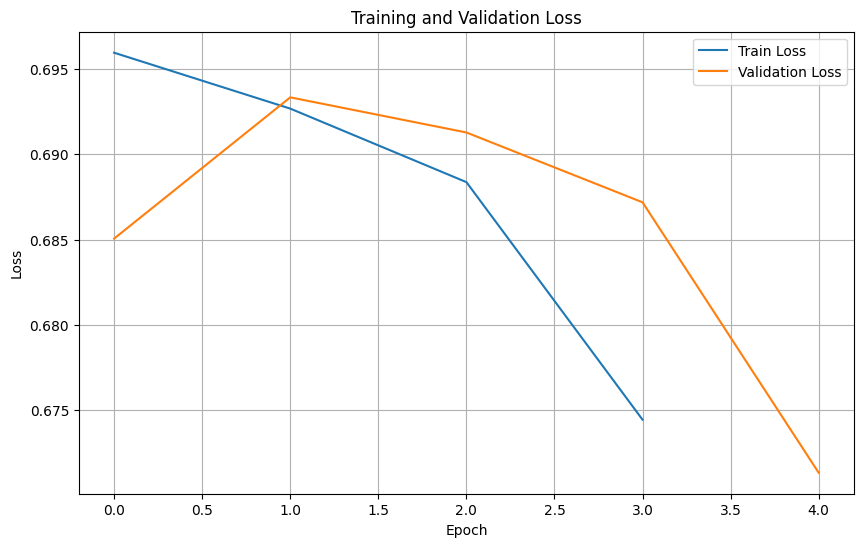

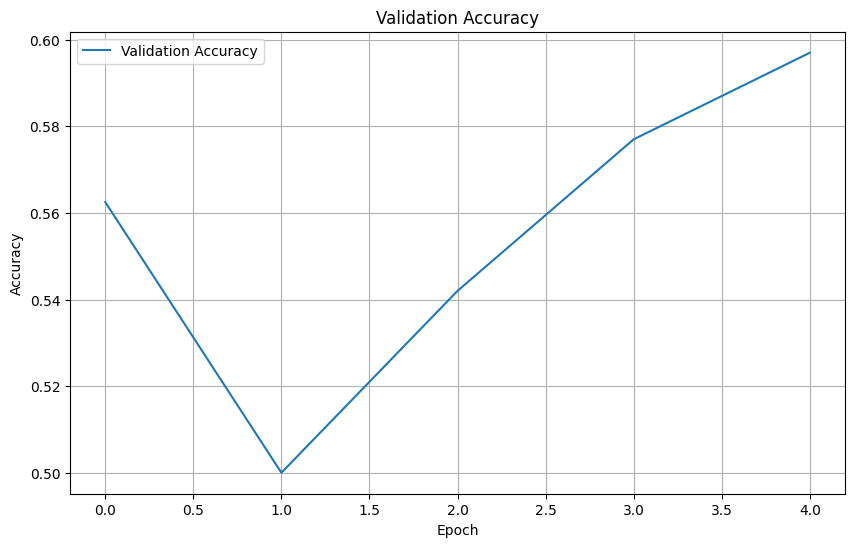

Test Loss: 0.6688432693481445
Test Accuracy: 0.6200000047683716


In [27]:
# 損失のプロット

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(metrics_logger.train_losses, label="Train Loss")
plt.plot(metrics_logger.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 検証精度のプロット
plt.figure(figsize=(10, 6))
plt.plot(metrics_logger.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# テスト結果の表示
if metrics_logger.test_losses and metrics_logger.test_accuracies:
    print(f"Test Loss: {metrics_logger.test_losses[-1]}")
    print(f"Test Accuracy: {metrics_logger.test_accuracies[-1]}")
else:
    print("No test results recorded.")

モデルの保存

In [24]:
# 保存
model_full_save_path = "comment_similarity_model_state_dict.pth"
torch.save(model.state_dict(), model_full_save_path)
print(f"Model state_dict saved to {model_full_save_path}")

Model state_dict saved to comment_similarity_model_state_dict.pth


特定の薬にターゲットをしぼる
トップ処方数を表示して選ぶ

In [15]:
# データの読み込み
file_path = "comments_physicians.csv"
comments_physicians = pd.read_csv(base_dir + file_path)
file_path = "evaluation.csv"
evaluation = pd.read_csv(base_dir + file_path)

# 結合前に、重複していない列を確認
unique_columns_in_evaluation = evaluation.columns.difference(comments_physicians.columns)

# 必要な列だけを評価データから選択
evaluation_filtered = evaluation[['evaluation_id'] + unique_columns_in_evaluation.tolist()]

# evaluation_idをキーにして結合
df = comments_physicians.merge(evaluation_filtered, on='evaluation_id', how='left')

# evaluation_idの型をintに統一（コピーを明示的に作成）
df = df.copy()  # 元データフレームをコピー
df['evaluation_id'] = df['evaluation_id'].astype(int)
df_filtered = df[df['drug_id'] == 1948].copy()  # drug_idフィルタリング後のデータをコピー
df_filtered['evaluation_id'] = df_filtered['evaluation_id'].astype(int)

# num_casesが多いものでソートして上位5件を抽出
top_comments = df_filtered.sort_values('num_cases', ascending=False).head().copy()
print(top_comments)

# 特定のevaluation_idを指定（もし指定がない場合、最上位を選択）
evaluation_id = 667199  # Noneの場合は自動的に最上位を選択
if evaluation_id is None:
    target_comment = top_comments.iloc[0]  # 最上位のコメントを選択
else:
    # 指定したevaluation_idが存在するか確認
    if evaluation_id in top_comments['evaluation_id'].values:
        target_comment = top_comments[top_comments['evaluation_id'] == evaluation_id].iloc[0]
    else:
        raise ValueError(f"Specified evaluation_id {evaluation_id} not found in the filtered dataset.")

# ターゲットコメントの取得
target_text = target_comment['comment']
print(f"Target comment: {target_text}")

# ターゲットコメント以外をフィルタリング
comparison_comments = df_filtered[df_filtered['evaluation_id'] != target_comment['evaluation_id']]
print(f"Number of comparison comments: {len(comparison_comments)}")



        evaluation_id  comment_id  user_id  drug_id drug_name area  \
77013          213998       41038   169213     1948    アミティ-ザ  便秘症   
188652         667199       14316   243223     1948    アミティ-ザ  便秘症   
209820         784138      219047      467     1948    アミティ-ザ  便秘症   
76917          213815       40942   139384     1948    アミティ-ザ  便秘症   
76992          213954       41017   175740     1948    アミティ-ザ  便秘症   

               evaluated_at  \
77013   2017-10-03 23:04:06   
188652  2021-08-21 20:31:00   
209820  2022-09-19 12:55:42   
76917   2017-10-03 17:51:17   
76992   2017-10-03 21:21:57   

                                                  comment  age pref gender  \
77013   小腸で水分を加えるタイプの下剤です。効果が十分ですが、下痢になってしまう人も多くて、1日2カ...   60  千葉県      男   
188652  副作用もなく、比較的投与しやすいと思います。まずは、プルセニド、アロ-ゼン、マグミット等処方...   60  北海道      男   
209820  下痢の発現がやや多い感じがある。 このために、試用中である。 しかし、使い方に慣れてくると、...   50  福岡県      男   
76917   薬価が高いのが気になる。もう少し薬価がやせければよい。患者さんによっては、下痢をするというケ...   70  鳥取県      男   
76

学習したデータで類似度の計算

In [17]:
# tqdmをインポート
from tqdm import tqdm
# GPU デバイスを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルをGPUに移動
model = model.to(device)

# 類似度計算用の関数（GPU対応版）
def compute_similarity(model, tokenizer, text1, text2):
    # トークン化とGPUへの移動
    inputs1 = tokenizer(text1, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(device)
    inputs2 = tokenizer(text2, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(device)

    # モデルで計算
    with torch.no_grad():
        similarity_score = model(
            input_ids1=inputs1['input_ids'],
            attention_mask1=inputs1['attention_mask'],
            input_ids2=inputs2['input_ids'],
            attention_mask2=inputs2['attention_mask']
        )
    return torch.sigmoid(similarity_score).item()

# Progress bar付きで類似度を計算
similarities = []
total_comments = len(comparison_comments)
with tqdm(total=total_comments, desc="Calculating similarities") as pbar:
    for _, row in comparison_comments.iterrows():
        similarity = compute_similarity(model, tokenizer, target_text, row['comment'])
        similarities.append(similarity)
        pbar.update(1)  # プログレスバーを更新

comparison_comments['similarity'] = similarities

# 'similarity'列で降順にソート
comparison_comments_sorted = comparison_comments.sort_values(by='similarity', ascending=False)

# Target text の行を一番上に挿入
target_row = pd.DataFrame([{
    'comment': target_text,
    'similarity': 1.0,  # 類似度は1として扱う（完全一致のため）
    **{col: target_comment[col] for col in comparison_comments.columns if col not in ['comment', 'similarity']}
}])

# ソート後のデータに行を挿入
result_df = pd.concat([target_row, comparison_comments_sorted], ignore_index=True)

# 結果をCSVとして保存
output_path = 'similarities.csv'
result_df.to_csv(base_dir + output_path, index=False)
print(f"Similarity results saved to {output_path}")

Calculating similarities: 100%|██████████| 889/889 [00:53<00:00, 16.53it/s]
<ipython-input-17-6781805d8aca>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_comments['similarity'] = similarities


Similarity results saved to similarities.csv


Similarity Statistics:
Mean: 0.5059
Median: 0.5036
Std: 0.0615
Min: 0.3346
Max: 0.6581


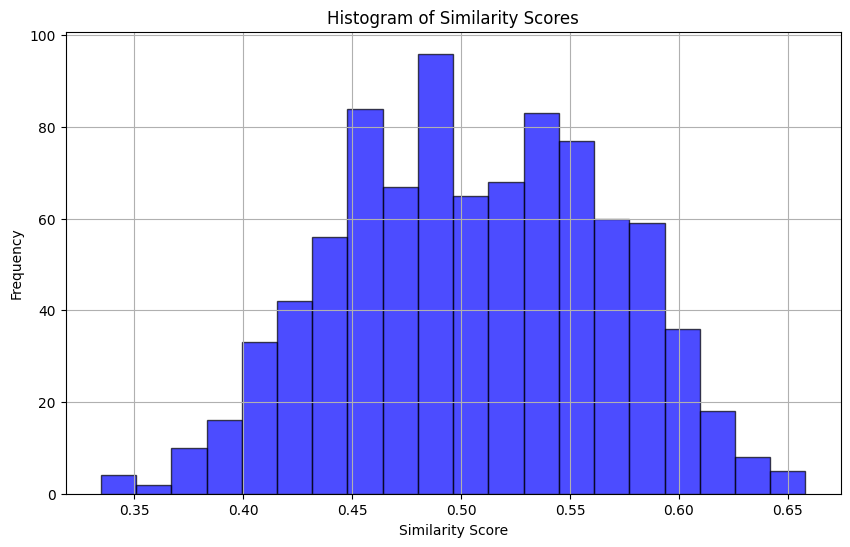

In [18]:
import matplotlib.pyplot as plt

# 統計量の計算
similarity_stats = {
    "mean": comparison_comments['similarity'].mean(),
    "median": comparison_comments['similarity'].median(),
    "std": comparison_comments['similarity'].std(),
    "min": comparison_comments['similarity'].min(),
    "max": comparison_comments['similarity'].max()
}

# 統計量の出力
print("Similarity Statistics:")
for key, value in similarity_stats.items():
    print(f"{key.capitalize()}: {value:.4f}")

# ヒストグラムのプロット
plt.figure(figsize=(10, 6))
plt.hist(comparison_comments['similarity'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
